In [486]:
# Read Data
import numpy as np
import pandas as pd


In [510]:
%run ../src/campus_src.py


In [489]:
df = pd.read_csv("../data/processed/campus_processed.csv")
df = df.set_index("DateTime")

## Create Dataset

In [490]:
# ÂÅáË®≠ df_encoded ÊòØ‰Ω†ÁöÑ DataFrameÔºå‰∏îÂ∑≤Á∂ìÊåâÊôÇÈñìÈ†ÜÂ∫èÊéíÂ∫è
#n_steps = 8  # ‰æãÂ¶ÇÔºå‰ΩøÁî®t‰ª•ÂèäÂâçÈù¢5Ê≠•‰ΩúÁÇ∫ÁâπÂæµ
#Ë´ñÊñáË®≠ÂÆöÊàê3
n_steps = 3
X, y = create_dataset(df.to_numpy(), n_steps)

print(y)
print(X.shape)
print(y.shape)

[222.326142 220.546435 205.955438 ...  73.581269 156.333926 222.44631 ]
(4316, 3, 35)
(4316,)


## Split

In [491]:
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(X, y, train_ratio=0.75, validation_ratio=0.15)

## Attack

In [492]:
def attack_all_add_pct(X, step_idx=7, feat_idx=1, pct=0.05):
    """
    ÂØπ X ‰∏≠ÊâÄÊúâÊ†∑Êú¨ÔºåÂú®ÊåáÂÆöÁöÑ step_idx Âíå feat_idx ‰ΩçÁΩÆÔºå
    Â∞ÜÂéüÂÄºÂ¢ûÂä† pct * ÂéüÂÄºÔºàÂç≥‰πò‰ª• 1+pctÔºâ„ÄÇ

    ÂèÇÊï∞Ôºö
        X (np.ndarray): ÂæÖ‚ÄúÊîªÂáª‚ÄùÁöÑ‰∏âÁª¥Êï∞ÁªÑÔºåshape=(n_samples, n_steps, n_features)
        step_idx (int): Êó∂Èó¥Ê≠•ÁöÑÁ¥¢ÂºïÔºåÊØîÂ¶ÇÁ¨¨8Ê≠•Â∞±‰º† 7
        feat_idx (int): ÁâπÂæÅÁöÑÁ¥¢ÂºïÔºåÊØîÂ¶ÇÁ¨¨2‰∏™ÁâπÂæÅÂ∞±‰º† 1
        pct (float): Â¢ûÂä†ÊØî‰æãÔºåÈªòËÆ§ 0.05Ôºà5%Ôºâ

    ËøîÂõûÔºö
        np.ndarray: ÊîªÂáªÂêéÁöÑÊï∞ÁªÑÂâØÊú¨
    """
    X_attacked = X.copy()
    X_attacked[:, step_idx, feat_idx] *= (1 + pct)
    return X_attacked

#X_test_attacked = attack_all_add_pct(X_test, step_idx=7, feat_idx=1, pct=0.2)
#X_test_attacked = attack_all_add_pct(X_test_attacked, step_idx=7, feat_idx=2, pct=0.2)

#X_test = X_test_attacked.copy()

## Scaler

In [493]:
X_train, X_validation, X_test = scaling(X_train, X_validation, X_test, 3)

## =====================

## Model

In [473]:
"""
for i in range(len(X_train)): #ÊØèÂÄãX_train
  # Â∫îÁî®Âô™Â£∞
  X_train[i] = add_noise(X_train[i], noise_level=0.05)
"""

'\nfor i in range(len(X_train)): #ÊØèÂÄãX_train\n  # Â∫îÁî®Âô™Â£∞\n  X_train[i] = add_noise(X_train[i], noise_level=0.05)\n'

In [495]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_validation = np.array(X_validation, dtype=np.float32)
y_validation = np.array(y_validation, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [553]:
# ÊûÑÂª∫Ê®°Âûã
look_back = n_steps;
n_features = X_train.shape[2]
#model = build_model_TCN(look_back, n_features)

batch_size = 128

"""‰∏æÂá†‰∏™Â∏∏ËßÅÁöÑ Œ± ÂÄºÁâπÁÇπÔºö

Œ±=1ÔºàBeta(1,1)ÔºâÔºöÂùáÂåÄÂàÜÂ∏ÉÔºåŒª Âú® [0,1] ‰∏äÁ≠âÊ¶ÇÁéá‚Äî‚ÄîÂèØËÉΩËêΩÂà∞ 0.1„ÄÅ0.9„ÄÅ0.5ÔºåÈÉΩÊòØ‰∏ÄÊ†∑ÁöÑÊ¶ÇÁéá„ÄÇ

Œ±=2 Êàñ 3ÔºàBeta(2,2) / Beta(3,3)ÔºâÔºöÊØîÂùáÂåÄÂàÜÂ∏ÉÊõ¥ÂÅèÂêë‰∏≠Èó¥ÔºåÊäΩÂà∞ 0.5 Â∑¶Âè≥ÁöÑÂá†Áéá‰ºöÊõ¥È´òÔºå‰ΩÜ‰πüËøò‰ºöÊúâÊØîËæÉÂ§ßÁöÑÊ¶ÇÁéáËêΩÂà∞ 0.2 Êàñ 0.8„ÄÇ

Œ±=5 Êàñ 10ÔºàBeta(5,5) / Beta(10,10)ÔºâÔºöÂàÜÂ∏ÉÂ∞±ÈùûÂ∏∏ÈõÜ‰∏≠Âú® 0.5 ÈôÑËøëÔºåÂá†‰πé‰∏ç‰ºöÊäΩÂá∫ 0.1 Êàñ 0.9ÔºåÂ§ßÈÉ®ÂàÜ Œª ÈÉΩÂú® 0.4‚Äì0.6ÔºàÁîöËá≥ 0.45‚Äì0.55Ôºâ‰πãÈó¥„ÄÇ
"""

model = WrapperTCNWithFGSMMixup(
    look_back=look_back,
    n_features=n_features,
    epsilon=0.2,   # FGSM Êâ∞Âä®ÂπÖÂ∫¶
    alpha=0.3,     # Beta(0.3,0.3)ÔºåMixup ÁöÑÂΩ¢Áä∂ÂèÇÊï∞
    step_idx=look_back-1, # Â¶ÇÊûúË¶Å‚ÄúÂÆöÁÇπÊâìÊâ∞‚ÄùÔºåÂèØ‰ª•ËÆæÁΩÆ‰∏Ä‰∏™Êï¥Êï∞
    feat_idx=1  # Â¶ÇÊûúË¶Å‚ÄúÂÆöÁÇπÊâìÊâ∞‚ÄùÔºåÂèØ‰ª•ËÆæÁΩÆ‰∏Ä‰∏™Êï¥Êï∞
)
# 2) compileÔºöÂè™Ë¶ÅÁªô‰∏Ä‰∏™ optimizer + loss_fnÔºå‰∏é build_model_TCN ‰∏≠ÁöÑ‰øùÊåÅ‰∏ÄËá¥Âç≥ÂèØ
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: tf.sqrt(
        tf.reduce_mean(tf.square(y_true - y_pred))
    )  # RMSE
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=batch_size,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]
)


# 5) ËØÑ‰º∞/È¢ÑÊµã
test_loss = model.evaluate(X_test, y_test)
y_pred    = model.predict(X_test)


/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_42"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ tcn_51 (TCN)                    ‚îÇ (None, 64)             ‚îÇ        97,664 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_126 (Dense)               ‚îÇ (None, 64)             ‚îÇ         4,160 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_127 (Dense)               ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_42 (Dropout)            ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_128 (Dense)               ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 103,937 (406.00 KB)

 Trainable params: 103,937 (406.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 70ms/step - loss: 97.0850 - val_loss: 41.3014
Epoch 2/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 65ms/step - loss: 37.6746 - val_loss: 17.5903
Epoch 3/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 60ms/step - loss: 19.9845 - val_loss: 13.0412
Epoch 4/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 64ms/step - loss: 16.3193 - val_loss: 12.3227
Epoch 5/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 66ms/step - loss: 16.1471 - val_loss: 11.4934
Epoch 6/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 68ms/step - loss: 14.3227 - val_loss: 11.8779
Epoch 7/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 64ms/step - loss: 14.8040 - val_loss: 12.0900
Epoch 8/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 65ms/step - loss: 14.0

In [556]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# original models.
model = build_model_TCN(look_back, n_features)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping]  # Âä†ÂÖ•Êó©ÊúüÂÅúÊ≠¢ÂõûË™øÂáΩÊï∏
)

/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Model: "sequential_43"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ tcn_52 (TCN)                    ‚îÇ (None, 64)             ‚îÇ        97,664 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_129 (Dense)               ‚îÇ (None, 64)             ‚îÇ         4,160 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_130 (Dense)               ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_43 (Dropout)            ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_131 (Dense)               ‚îÇ (None, 1)              ‚îÇ            33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 103,937 (406.00 KB)

 Trainable params: 103,937 (406.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 26ms/step - loss: 95.9011 - val_loss: 33.0788
Epoch 2/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 34.6315 - val_loss: 15.5159
Epoch 3/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 19.2443 - val_loss: 13.9150
Epoch 4/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14ms/step - loss: 17.6772 - val_loss: 14.3391
Epoch 5/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step - loss: 17.2670 - val_loss: 12.8276
Epoch 6/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - loss: 15.8013 - val_loss: 12.6448
Epoch 7/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step - loss: 16.0642 - val_loss: 12.0390
Epoch 8/100
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step - loss: 15.7

In [515]:
# ‚ÄúÂè™Ë¶Å step_idx, feat_idx Â∞±‰∏ÄÂÆöÁªôÈÇ£ÁÇπÂä† Œµ‚Äù Ôºü
# ‰∏çÂÆåÂÖ®ÂØπÔºåËøòË¶ÅÁúãËØ•ÁÇπÁöÑ grad_sign ÊòØÂê¶‰∏∫ 1„ÄÇÂ¶ÇÊûúÊ¢ØÂ∫¶ÊòØ 0Ôºà‰πüÂ∞±ÊòØÊ®°ÂûãËÆ§‰∏∫ÊîπÈÇ£‰∏™‰ΩçÁΩÆÊ≤°Ê≥ïÂ¢ûÂ§ßÊçüÂ§±ÔºâÔºågrad_sign ‰ºöÊòØ 0Ôºå‰∫éÊòØ‰Ω†Âú®ËøôÊÆµ‰ª£Á†ÅÈáå Âπ∂‰∏ç‰ºöÊää epsilon Âä†ËøáÂéª„ÄÇ

# ‚Äú‰ºö‰∏ç‰ºöÊúâÊüê‰∫õÁÇπÂä†Ë∂ÖËøá 20%ÔºåÊüê‰∫õÁÇπ‰∏çÂä†Ôºü‚Äù

# ‚ÄúÂä†Ë∂ÖËøá 20%‚ÄùÔºö‰∏ç‰ºö„ÄÇÂõ†‰∏∫‰Ω†Âè™Âú® grad_sign=1 ÁöÑÂú∞ÊñπÂä†‰∏ä‰∫Ü‰∏Ä‰∏™‚ÄúÊÅíÂÆö‚ÄùÁöÑ epsilonÔºàËøôÈáå epsilon=0.2ÔºâÔºåÁªùÂØπ‰∏çÂèØËÉΩÂä†Ë∂ÖËøá 0.2„ÄÇ

# ‚ÄúÊüê‰∫õÁÇπ‰∏çÂä†‚ÄùÔºö‰ºö„ÄÇÈÇ£ÊòØÂõ†‰∏∫Â¶ÇÊûú grad_sign Âú® (step_idx, feat_idx) ‰ΩçÁΩÆ‰∏∫ 0ÔºåÈÇ£‰πà grad_sign * mask Â∞±ÊòØ 0ÔºåËá™ÁÑ∂‰∏çÂä†‰ªª‰Ωï‰∏úË•ø„ÄÇ‰πüÂ∞±ÊòØËØ¥ÔºåÊúâÁöÑÊ†∑Êú¨Âú®ÈÇ£‰∏™‰ΩçÁΩÆÊ¢ØÂ∫¶ÊòØË¥üÊàñ 0ÔºåÂ∞±‰∏ç‰ºöË¢´ÊîπÂä®„ÄÇ

#ÂÆöÁÇπÊâ∞Âä®ÔºàÊÇ®ÂéüÂßãÁöÑÈúÄÊ±ÇÔºâÔºö
# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     y, 
#     epsilon=0.1,
#     step_idx=7, 
#     feat_idx=1
# )
# #ÂÖ®Â±ÄÊâ∞Âä®Ôºà‰∏éÂéüÂßãFGSMÁõ∏ÂêåÔºâÔºö
# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     y, 
#     epsilon=0.1
#     # ‰∏çÊåáÂÆöstep_idxÂíåfeat_idx
# )

#ÊÉ≥ËÆ©ÂÆÉÈÉΩÈ¢ÑÊµãÊàêÂéüÊù•ÁöÑ‰∏§ÂÄçÔºåÂ∞±ÂÜô target_labels = y_test * 2.0
#ÂÆöÂêëÊîªÂáªÔºö

# adv_x = fgsm_inject_one_pos(
#     model, 
#     X, 
#     target_y,  # ‰º†ÂÖ•ÁõÆÊ†áÊ†áÁ≠æ
#     epsilon=0.1,
#     targeted=True
# )
 
# targeted ÊîØÊåÅ‰Ω†ÈÄâÊã©ÊòØÂÅöÊôÆÈÄöÁöÑ untargeted ÂºèÁôΩÂ∏ΩÊîªÂáªÔºàÊúÄÂ§ßÂåñÊ≠£Á°ÆÊ†áÁ≠æÊçüÂ§±ÔºâÔºåËøòÊòØÂÅöÈíàÂØπÊüê‰∏™ÁõÆÊ†áÊ†áÁ≠æÁöÑ targeted ÊîªÂáªÔºàÊúÄÂ∞èÂåñÁõÆÊ†áÊ†áÁ≠æÊçüÂ§±Ôºâ„ÄÇ


# ‚Äî‚Äî ‰ΩøÁî®Á§∫‰æã ‚Äî‚Äî #
epsilon = 0.2
X_test_adv = None
# Êó∂Èó¥Áª¥Â∫¶‰∏äÔºåËÆ∫Êñá‰∏≠ÁöÑ FGSM Âè™ÈíàÂØπ ÂΩìÂâçÊó∂Âàª ùë° ÁöÑÂø´ÁÖßËøõË°åÊâ∞Âä®Ôºå‰∏ç‰ºö‚ÄúËøûÂ∏¶‚ÄùÊää ùë° ‚àí 1 , ùë° ‚àí 2 , ‚Ä¶ t‚àí1,t‚àí2,‚Ä¶ ‰∏ÄÂπ∂ÊîπÂä®Ôºõ
X_test_adv = fgsm_inject_one_pos(model, X_test, y_test, epsilon)#, step_idx=n_steps-1, feat_idx=1)
X_test_adv = fgsm_inject_one_pos(model, X_test_adv, y_test, epsilon)#, step_idx=n_steps-1, feat_idx=2)
preds_clean = model.predict(X_test)
preds_adv   = model.predict(X_test_adv)    # ‰∏ÄÂÆöË¶Å‰º† X_test_adv
print("max abs diff:", np.max(np.abs(preds_adv - preds_clean)))

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step 
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 
max abs diff: 54.726288


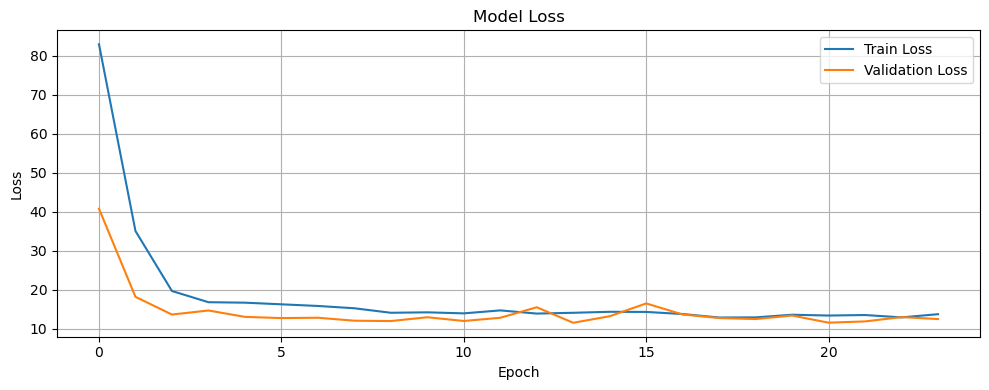

In [545]:
plot_loss(history)

Testing Length: 432
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step


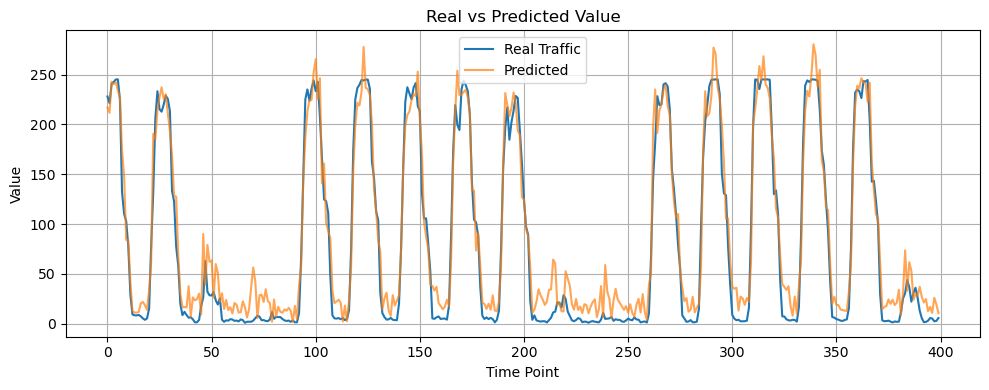

In [557]:
plot_predictions(model, X_test_adv, y_test, start=0, end=400)

Testing Length: 432
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step 


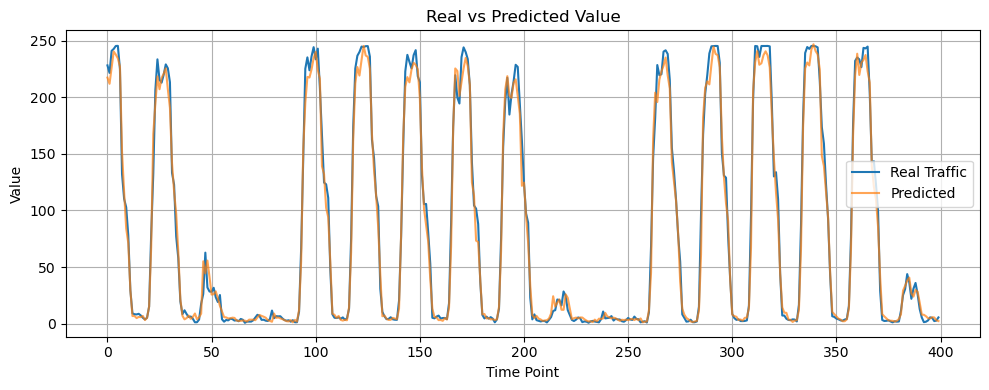

In [558]:
plot_predictions(model, X_test, y_test, start=0, end=400)

In [559]:
predicted = model.predict(X_test).reshape(-1, 1)
result_normal = evaluate_regression(y_test, predicted)

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step 
Mean Absolute Error: 6.218408107757568
Mean Squared Error: 90.44013977050781
Root Mean Squared Error: 9.510002090983356
R^2 Score: 0.9896119832992554
Mean Absolute Percentage Error: 0.35264700651168823


In [560]:
predicted = model.predict(X_test_adv).reshape(-1, 1)
result_attacked = evaluate_regression(y_test, predicted)

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step 
Mean Absolute Error: 17.275178909301758
Mean Squared Error: 444.7889404296875
Root Mean Squared Error: 21.09001992482908
R^2 Score: 0.9489111304283142
Mean Absolute Percentage Error: 3.019653797149658


In [330]:
# Create a DataFrame to compare the values
df_compare = pd.DataFrame({
    'Metric': list(result_normal.keys()),
    'Normal': list(result_normal.values()),
    'Attacked': list(result_attacked.values())
})

# Calculate absolute and percentage differences
df_compare['Absolute Difference'] = df_compare['Attacked'] - df_compare['Normal']
df_compare['% Difference'] = ((df_compare['Absolute Difference'] / df_compare['Normal']) * 100)
df_compare

Metric      Normal    Attacked  Absolute Difference  % Difference
0    MAE    6.848458    9.084687             2.236229     32.653036
1    MSE  110.009964  157.027420            47.017456     42.739270
2   RMSE   10.488563   12.531058             2.042495     19.473541
3     R2    0.987364    0.981964            -0.005400     -0.546959
4   MAPE    0.382416    0.767118             0.384701    100.597517

In [ ]:
import os
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# ÂÆöÁæ©‰∏ÄÂÄãÂáΩÂºèÔºåÂº∑Âà∂Âæû _1 ÈñãÂßã‰æùÂ∫èÁ∑®ËôüÊ™îÂêç
def get_unique_filename(filename):
    """
    ‰∏çË´ñÊ™îÊ°àÊòØÂê¶Â≠òÂú®ÔºåÁöÜÂæû _1 ÈñãÂßãÈôÑÂä†Âà∞Ê™îÂêç‰∏äÔºå
    Ëã•ÊúâÂêåÊ®£Á∑®ËôüÁöÑÊ™îÊ°àÂ≠òÂú®ÔºåÂâá‰æùÂ∫èÁ¥ØÂä†Á∑®ËôüÔºåÁõ¥Âà∞ÊâæÂà∞Â∞ö‰∏çÂ≠òÂú®ÁöÑÊ™îÂêç„ÄÇ
    """
    base, ext = os.path.splitext(filename)
    i = 1
    unique_filename = f"{base}_{i}{ext}"
    while os.path.exists(unique_filename):
        i += 1
        unique_filename = f"{base}_{i}{ext}"
    return unique_filename

# ------------------------
# Â∞çÊ∏¨Ë©¶ÈõÜÈÄ≤Ë°åÈ†êÊ∏¨ÂèäË®àÁÆóÊåáÊ®ô
# ------------------------

# ÈÄ≤Ë°åÊ∏¨Ë©¶ÈõÜÈ†êÊ∏¨‰∏¶ËΩâÊèõÊàê‰∏ÄÁ∂≠Èô£Âàó
predicted_test = model.predict(X_test).reshape(-1, 1)

# Ë®àÁÆóÂêÑÈ†ÖÂõûÊ≠∏Ë©ï‰º∞ÊåáÊ®ô
mse = mean_squared_error(y_test, predicted_test)
mae = mean_absolute_error(y_test, predicted_test)
rmse = sqrt(mse)
r2 = r2_score(y_test, predicted_test)
mape = mean_absolute_percentage_error(y_test, predicted_test)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')
print(f'MAPE: {mape}')

# Â∞áÊ∏¨Ë©¶ÈõÜÁúüÂÄºËàáÈ†êÊ∏¨ÁµêÊûúÂêà‰ΩµÊàê DataFrame
test_results = pd.DataFrame({
    'True': y_test.flatten(),
    'Predicted': predicted_test.flatten()
})

# ÂèñÂæóÂîØ‰∏ÄÊ™îÂêç‰∏¶ÂÑ≤Â≠òÊ∏¨Ë©¶ÈõÜÁµêÊûúÊàê CSV Ê™îÊ°à
test_csv_filename = get_unique_filename('test_predictions.csv')
test_results.to_csv(test_csv_filename, index=False)
print(f"Ê∏¨Ë©¶ÈõÜÁµêÊûúÂÑ≤Â≠òÂà∞Ê™îÊ°à: {test_csv_filename}")

# ------------------------
# Â∞çË®ìÁ∑¥ÈõÜÈÄ≤Ë°åÈ†êÊ∏¨‰∏¶ÂÑ≤Â≠òÁµêÊûú
# ------------------------

# È†êÊ∏¨Ë®ìÁ∑¥ÈõÜË≥áÊñô
predicted_train = model.predict(X_train).reshape(-1, 1)

# Â∞áË®ìÁ∑¥ÈõÜÁúüÂÄºËàáÈ†êÊ∏¨ÁµêÊûúÂêà‰ΩµÊàê DataFrame
train_results = pd.DataFrame({
    'True': y_train.flatten(),
    'Predicted': predicted_train.flatten()
})

# ÂèñÂæóÂîØ‰∏ÄÊ™îÂêç‰∏¶ÂÑ≤Â≠òË®ìÁ∑¥ÈõÜÁµêÊûúÊàê CSV Ê™îÊ°à
train_csv_filename = get_unique_filename('train_predictions.csv')
train_results.to_csv(train_csv_filename, index=False)
print(f"Ë®ìÁ∑¥ÈõÜÁµêÊûúÂÑ≤Â≠òÂà∞Ê™îÊ°à: {train_csv_filename}")

# ÁµêÊûúÂàÜÊûê

## ÊØèÂ∞èÊôÇË™§Â∑Æ

In [ ]:
for index, row in df_extraction.iterrows():
  for i in range(len(y_test)):
    if (row["value_avg"]/1000000) == y_test[i]:
      df_extraction.loc[index, "predicted"] = predicted[i][0]

In [ ]:
df_extraction_hour = df_extraction.dropna()

In [ ]:
df_extraction_hour["value_avg"] = df_extraction_hour["value_avg"] / 1000000

In [ ]:
df_extraction_hour

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["hour"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(24)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each hour')
plt.xticks(hours)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = df_extraction_hour.copy()

hours = data.groupby(data["weekday"])

mae = hours.apply(lambda x: np.mean(np.abs(x['value_avg'] - x['predicted'])))
rmse = hours.apply(lambda x: np.sqrt(np.mean((x['value_avg'] - x['predicted'])**2)))
mape = hours.apply(lambda x: np.mean(np.abs((x['value_avg'] - x['predicted']) / x['value_avg'])) * 100)

print('MAE for each hour:')
print(mae)
print('\nRMSE for each hour:')
print(rmse)
print('\nMAPE for each hour:')
print(mape)

hours = range(7)
plt.figure(figsize=(12, 6))
plt.plot(hours, mae, label='MAE')
plt.plot(hours, rmse, label='RMSE')
plt.plot(hours, mape, label='MAPE')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.title('MAE, RMSE and MAPE for each weekday')
plt.xticks(hours)
plt.legend()
plt.show()